# TP I : Support Vector Machines

Ce TP vise à apporter les éléments nécessaires pour comprendre les implementations d'algorithmes de classification autour des SVM. **C'est un *TP à trous* ; il s'agira de compléter ces trous et d'y ajouter les tests qui vous sembleront utiles.**

Voici un aperçu des points abordés lors de ce TP.

- partie I
    - Importation et visualisation des données
- partie II
    - SVM Linéaire
- partie III
    - SVM non-Linéaire
    
Dans l'ensemble du déroulé du TP vous ferez bien attention à valider par un jeu de tests la validité des programmes écrits. Vous regarderez l'influence des paramètres sur la convergence. Vous comparerez les intérêts des diférentes méthodes les unes par rapport aux autres.

**Votre démarche et vos conclusions seront présentées sous forme d'un rapport (de 5 à 10 pages) où vous pourrez choisir d'avoir une approche plus sur les résultats mathématiques ou sur les résultats numériques. Le notebook Jupiter avec l'ensemble de vos travaux sera aussi remis. Ces deux éléments devront être remis au plus tard le mercredi 28 décembre.**


## Attendus de rendu

Votre rendu sera jugé à l'aune de

- votre capacité à produire des algorithmes valides, répondant à la question posée
- l'étude effectuée concernant la sensibilité de vos algorithmes aux hyperparamètres / conditions initiales
- l'analyse comparative proposée quant aux différentes implémentations suggérées 
- les stress-tests auxquels vous aurez confrontés vos implémentations. 

On portera une attention particulière à la *généricité* de votre réponse ; tout comme cela vous est suggéré par la suite on attendra de vous d'appuyer vos affirmations par suffisamment de tests et une appréciation pour les limites de votre analyse.

Ce TP est à rendre par **groupes de 3** et exceptionnellement **2**.

# Au travail!

In [1]:
import warnings
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## I- Importation et préparation des données

Nous allons ici introduire quelques datasets qui permettront de tester les méthodes.


### 1. Importation

Importer **data1** le dataset proposé pour faire les premiers tests



In [2]:
df1 = pd.read_excel('data/data1.xlsx')

In [3]:
df1.head(10)

,échantillon,caractère1,caractère2,classe
0,1,0.5,2.5,1
1,2,0.8,2.8,1
2,3,1.5,3.5,1
3,4,0.2,0.2,-1
4,5,0.6,0.6,-1
5,6,1.7,1.7,-1
6,7,1.0,4.0,1
7,8,0.6,3.0,1
8,9,1.5,0.5,-1


Identifier la colonne qui servira à classifier et qui ne prend donc que 2 valeurs.

La colonne qui nous servira a classifier dans ce premier dataset est la colonne `classe` qui ne prend que 2 valeurs : -1 et 1.

### 2. Visualisation

Visualiser les deux premières colonnes qui ont des valeurs numériques, sous forme d'un nuage de points (avec un marqueur différent en fonction de la valeur servant à classifier).

In [4]:
def visu(df_):
    value=(df_['classe']>0)
    df_['color']= np.where( value==True , "red", "blue")

    plt.scatter(df_.iloc[:,1],df_.iloc[:,2],color= df_.color)
    plt.show()

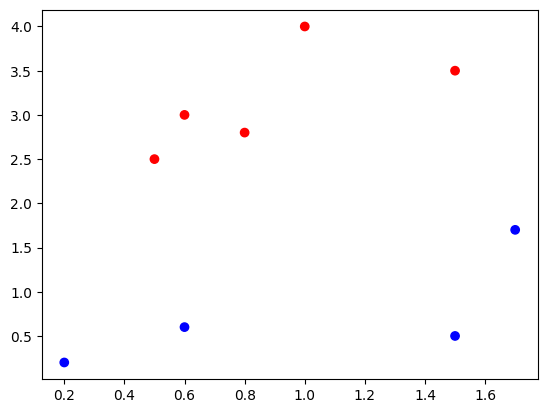

In [5]:
visu(df1)

In [6]:
df1.head(10)

,échantillon,caractère1,caractère2,classe,color
0,1,0.5,2.5,1,red
1,2,0.8,2.8,1,red
2,3,1.5,3.5,1,red
3,4,0.2,0.2,-1,blue
4,5,0.6,0.6,-1,blue
5,6,1.7,1.7,-1,blue
6,7,1.0,4.0,1,red
7,8,0.6,3.0,1,red
8,9,1.5,0.5,-1,blue


Regarder aussi les fichiers **data2**, **data3** et **data4**

In [7]:
df2 = pd.read_excel('data/data2.xlsx')
df3 = pd.read_excel('data/data3.xlsx')
df4 = pd.read_excel('data/data4.xlsx')

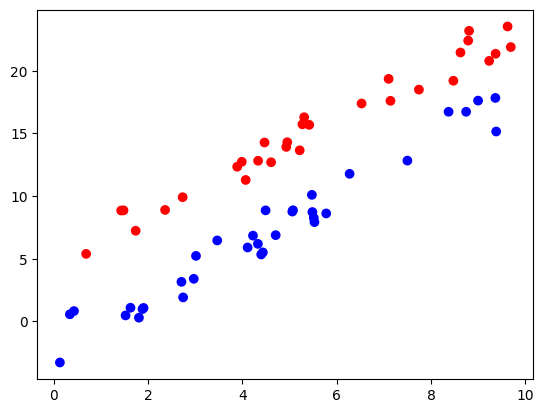

In [8]:
visu(df2)

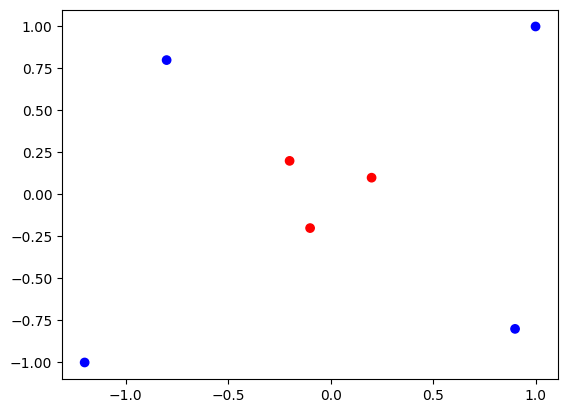

In [9]:
visu(df3)

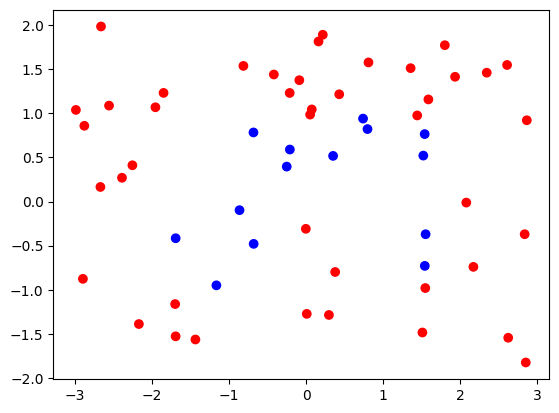

In [10]:
visu(df4)

## II- SVM - le cas linéaire

Nous allons ici rappeler les points essentiels qui ont été vus en cours et qui serviront à l'implémentation de l'algorithme.

On a une population de $n$ individus.

On dispose, pour chaque individu $i$, de ses caractéristiques $X_i \in \mathbb{R}^p$ et d'un indicateur de décision $y_i \in \{ -1 ; +1\}$.

Le problème de SVM linéaire revient à chercher $(\omega,b)\in \mathbb{R}^p \times \mathbb{R}$ tel que $(\omega,b)$ soit solution du problème d'optimisation sous contraintes:

$\displaystyle (HM):\quad \min_{\begin{matrix} \omega,b \, t.q. \\ y_i\left( \omega . X_i  - b\right) \ge 1 \\ 1\le i \le N \end{matrix}}\frac{1}{2}||\omega||^2$.

Géométriquement cela revient à séparer les points $X_i$ par des hyperplans:
- $\omega . X  - b = 0$ qui sera l'hyperplan de décision.
- Les deux hyperplans $\omega . X  - b = +1$ et $\omega . X  - b = -1 $ étant espacés au maximum tout en gardant les points tels que $y_i=+1$ et $y_i=-1$ à l'extérieur de la bande qu'ils délimitent.

Le problème ci-dessus est le **problème primal**. Nous avons vu en cours sur l'optimisation sous contrainte (et après introduction du Lagrangien), que ce problème est équivalent au **problème dual**

$\displaystyle (HM*):\quad \min_{\begin{matrix} \alpha_i \ge 0 \\ \sum \alpha_i y_i =0 \end{matrix}}\frac{1}{2}\sum_{1\le i,j \le N} \alpha_i \alpha_j y_i y_j X_i^TX_j-\sum_{1\le i \le N}\alpha_i$.

où les inconnues sont les $(\alpha_1,\cdots, \alpha_n)$ qui sont les multiplicateurs de Lagrange.

Si on note $G=\big(y_i y_j X_i ^T X_j \big)_{\begin{matrix} 1 \le i \le N \\ j \le i \le N \end{matrix}}$, la matrice de Gram, le problème s'écrit:

$\displaystyle (HM*):\quad \min_{\begin{matrix} \alpha_i \ge 0 \\ \sum \alpha_i y_i =0 \end{matrix}}\frac{1}{2} \alpha^TG\alpha-\sum_{1\le i \le N}\alpha_i$.

Ce problème peut se résoudre en utilisant par exemple un algorithme de gradient projeté car $\displaystyle \{ \alpha \in \mathbb{R}^N \, t.q. \, \alpha_i \ge 0 \, , \, 1 \le i \le N  \, et \, \sum_{i=0}^n \alpha_i y_i =0 \}$ est un convexe sur lequel il est "relativement" facile de projeter un vecteur de $ \mathbb{R}^N$


Une fois les $\alpha=(\alpha_1,\cdots,\alpha_N)$ calculés, on se souvient que comme on est situé au niveau du point selle du Lagrangien, on a aussi $\displaystyle \omega = \sum_{1 \le i \le N}\alpha_i yi X_i$. Cela nous permet de calculer $\omega$

On remarque que beaucoup de $\alpha_i$ sont nuls, ce qui signifient que ces contraintes ne sont pas qualifiées (au sens de la théorie du Lagrangien). Les $i$ qui correspondent à des $\alpha_i \neq 0$ correspondent aux Support Vectors (c'est à dire aux $X_i$ situés sur les hyperplans définissant la marge) et donc $F(X_i) = \pm 1$ pour ces vecteurs.

On pourra se servir de la remarque ci-dessus pour calculer $b$.

On aura donc ainsi entièrement défini notre hyperplan qui constitue la "decision boundary".

**On peut aussi voir les choses un peu différemment (et cela sera utile plus tard pour traiter le cas non linéaire):**
- En introduisant la fonction $\displaystyle F(X) = \sum_{1 \le i \le N}\alpha_i yi X_i^T X - b$ qui va de $\mathbb{R}^m \times \mathbb{R}^m \to \mathbb{R}$.

- On a $C_0 F$ qui est l'hyperplan de séparation entre les points $+1$ et les points $-1$. et $C_{-1} F$ et $C_{+1} F$ sont les deux hyperplans de marge (on rappelle que $C_k F$ est la courbe de niveau de valeur $k$ pour la fonction $F$, c'est à dire $\{ X \in \mathbb{R}^m \, t.q. F(X)=k \}$ ).


### 1. Le gradient projeté

Créer un algorithme de descente de gradient (par exemple récupéré dans le TP de descente de gradient de OCVX1).
Le modifier pour qu'à chaque pas de descente, le gradient soit projeté sur $\{ \alpha \in \mathbb{R}^N \, t.q. \, \alpha_i \ge 0 \, , \, 1 \le i \le N  \, et \, \sum_{i=0}^n \alpha_i y_i =0 \}$.


In [11]:
def partial(f, x, i=0, dx=1e-6):
    """Computes i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: coordinate along which derivative is computed.
        dx: slack for finite difference.
        
    Output:
        (float)

    """
    h = np.zeros(x.size)
    h[i] = dx
    return (f(x + h) - f(x - h)) / (2*dx)

In [12]:
def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
        
    """
    dim=x.size
    grad=np.zeros(dim)
    for i in range(dim):
        grad[i]=partial(f,x,i,dx)
    
    return grad

In [13]:
# Cette fonction génère la taille du pas optimal vérifiant le critère d'Amijo

def backtrack(x0, f , dir_x, alpha = 0.4, beta = 0.8):
    """
    Description: 
    Parameters:
    x0: point actuel
    f: fonction à minimiser
    dir_x: direction dans laquelle on souhaite aller
    
    Output
    valeur du pas optimal
    """
    t=1
    grad=gradient(f,x0)

    # On teste qu'on est bien dans une direction de descente
    if dir_x.T @ grad < 0:        
        while True:
            if f(x0 + t*dir_x) < f(x0) + alpha * t * dir_x.T @ grad:
                break
            t =t * beta
    return t

**C'est la fonction ci-dessous qu'il faut modifier**

In [14]:
def projection(x, y):
    """
    Description:
    Projection sur le plan somme(alpha_i yi)=0 et R+^n
    
    Parameters:
    x: point à projeter
    y: vecteur de contrainte
    
    Output:
    x_p: point projeté
    """
    x_p = x - ((x @ y) / np.linalg.norm(y)**2) * y
    x_p[x_p < 0] = 0
    return x_p


def desc_grad_opti_proj(f, y, p0, eps=1E-5):
    x = [np.array(p0)]

    while True:

        descente = -gradient(f,x[-1])
        mu = backtrack(x[-1], f, descente)
        # x.append(x[-1] + mu * descente)
        # modifier la ligne ci-dessus pour projeter sur le convexe R+^n et le plan somme(alpha_i yi)=0 
        x.append(projection(x[-1] + mu * descente, y))

        # test de convergence
        if np.square(x[-1]-x[-2]).sum() < eps**2 :
            break
        # tests de protection
        if np.square(x[-1] - x[-2]).sum() > 1E9:  # au cas où on diverge
            print("DIVERGE")
            break
        if len(x) > 30000:  # c'est trop long, je crains la boucle infinie
            print('Trop long, boucle infinie ?')
            break
    return np.array(x)

### 2. Résolution du problème dual

Créer une fonction prepa_donnees qui prépare les données dont on a besoin (df,X,y,Gram) pour la résolution du problème dual à partir d'un fichier "nom_data".

In [15]:
def prepa_donnees(nom_data):
    """
    Description: 
    Parameters:
    nom_data: nom du fichier dans lequel aller chercher les données
    
    Output
    df: dataframe panda contenant les données
    X: un tableau numpy de taille (nb_individus x nb_caractéristiques) contenant les caractéristiques des individus
    y: un vecteur numpy de taille (nb_individus) contenant les classificateurs (+1 ou -1)
    Gram: la matrice de Gram du problème de taille (nb_individus x nb_individus)
    """
    df = pd.read_excel(nom_data)
    X = df.iloc[:,1:3].to_numpy()
    y = df.iloc[:,-1].to_numpy()
    Gram = np.outer(y, y) * (X @ X.T)
    return df,X,y,Gram

Définir une fonction qui définit la fonctionnelle à minimiser $\displaystyle J(\alpha)=  \frac{1}{2} \alpha^TG\alpha-\sum_{1\le i \le N}\alpha_i$

In [16]:
def J(alpha, Gram):
    """
    Description: 
    Parameters:
    alpha: vecteur de taille (nb_individus) contenant les poids des individus
    
    Output
    J: la valeur de la fonction objectif
    """
    return 0.5 * alpha.T @ Gram @ alpha - alpha.sum()

Avec les modules que vous venez de créer, vous pouvez maintenant calculer les valeurs de $\alpha_1,\cdots,\alpha_N$ comme étant la solution du problème $(HM*)$. Commencez avec le fichier **data1**




In [54]:
df, X, y, Gram = prepa_donnees('data/data1.xlsx')
alpha = desc_grad_opti_proj(lambda alpha: J(alpha, Gram), y, np.zeros(len(y)))[-1]
print(alpha)

[0.61758825 0.38219506 0.         0.         0.06383189 0.92694025
 0.         0.         0.        ]


Calculer maintenant $\omega$ et $b$. Ici on aura $\omega = (a_1,a_2)$ et notre hyperplan se limitera à la droite $a_1 x + a_2 y +b=0$.


In [55]:
def calcul_w(X, y, alpha):
    """
    Description: 
    Parameters:
    X: un tableau numpy de taille (nb_individus x nb_caractéristiques) contenant les caractéristiques des individus
    y: un vecteur numpy de taille (nb_individus) contenant les classificateurs (+1 ou -1)
    alpha: vecteur de taille (nb_individus) contenant les poids des individus
    
    Output
    w: vecteur de taille (nb_caractéristiques) contenant les coefficients de la droite de séparation
    """
    return (alpha * y) @ X

In [56]:
w = calcul_w(X, y, alpha)

In [57]:
a1 = w[0]
a2 = w[1]
a1, a2

(-0.9995473858146844, 1.0000192478506498)

In [58]:
def calcul_b(X, y, alpha, w):
    """
    Description: 
    Parameters:
    X: un tableau numpy de taille (nb_individus x nb_caractéristiques) contenant les caractéristiques des individus
    y: un vecteur numpy de taille (nb_individus) contenant les classificateurs (+1 ou -1)
    alpha: vecteur de taille (nb_individus) contenant les poids des individus
    w: vecteur de taille (nb_caractéristiques) contenant les coefficients de la droite de séparation
    
    Output
    b: le coefficient de la droite de séparation
    """
    N = np.sum(alpha > 0)
    b = 0
    for i in range(len(y)):
        if alpha[i] > 0:
            b += y[i] - w @ X[i]
    return b / N


In [59]:
b1 = calcul_b(X, y, alpha, w)
print(b1)

-1.0004439236830187


Visualisez les résultats en reprenant la visualisation du nuage de nos points réalisé au $\bf{I-2}$ et en rajoutant les hyperplans caractéristiques qu'on vient de calculer.

A ce stade ... si tout se passe bien vous avez dû trouver, en utilisant les données de **data1**, que la frontière de décision est la droite $y=x+1$ et que les deux frontières pour la marge maximum sont les droites  $y=x$ et $y=x+2$.

In [60]:
def visu_front(df,a1_,a2_,b_):
    value=(df['classe']>0)
    df['color']= np.where(value==True , "red", "blue")
    plt.scatter(df.iloc[:,1], df.iloc[:,2], color=df.color)
    x = np.linspace(0,10,100)
    y = (-a1_ * x - b_) / a2_
    plt.plot(x,y)
    plt.show()

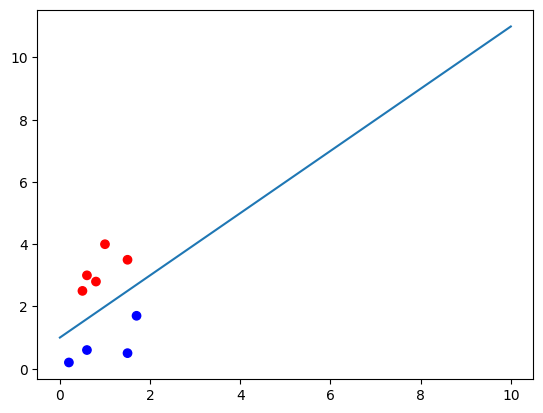

In [62]:
visu_front(df, a1, a2, b1)

### 3. Cas plus large et cas non séparable linéairement

Tester ce que vous venez de faire sur **data2** et **data3**.
Que remarquez vous?

Trop long, boucle infinie ?


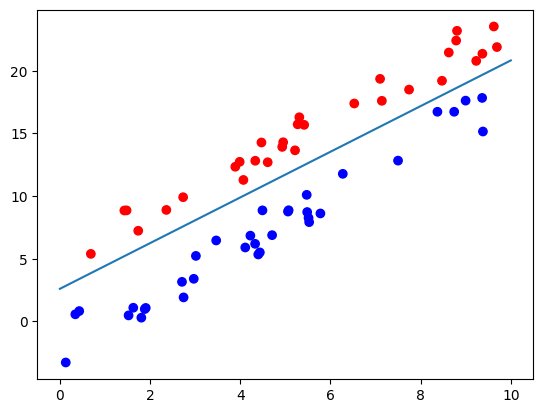

In [64]:
df2, X2, y2, Gram2 = prepa_donnees('data/data2.xlsx')
alpha2 = desc_grad_opti_proj(lambda alpha: J(alpha, Gram2), y2, np.zeros(len(y2)))[-1]
w2 = calcul_w(X2, y2, alpha2)
b2 = calcul_b(X2, y2, alpha2, w2)
a1_2, a2_2 = w2[0], w2[1]
visu_front(df2, a1_2, a2_2, b2)

Trop long, boucle infinie ?


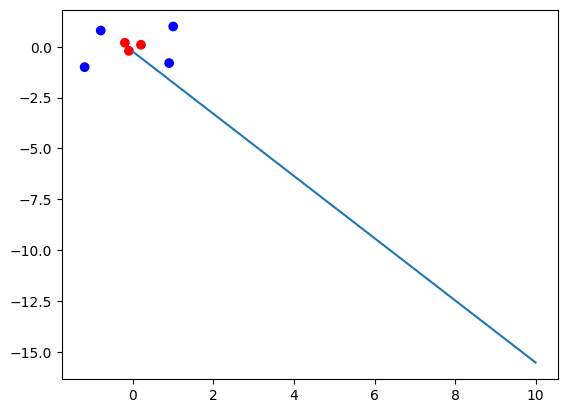

In [66]:
df3, X3, y3, Gram3 = prepa_donnees('data/data3.xlsx')
alpha3 = desc_grad_opti_proj(lambda alpha: J(alpha, Gram3), y3, np.zeros(len(y3)))[-1]
w3 = calcul_w(X3, y3, alpha3)
b3 = calcul_b(X3, y3, alpha3, w3)
a1_3, a2_3 = w3[0], w3[1]
visu_front(df3, a1_3, a2_3, b3)

On remarque une bonne délimitation pour le **data2** mais pas pour le **data3**. En effet, le **data3** n'est pas séparable linéairement. On va donc devoir utiliser une méthode plus générale, avec un noyau différent, notamment le noyau polynomial.

## III - SVM - le cas non linéaire - "the Kernel Trick"

Comme nous avons vu en TD, on peut chercher à séparer nos points avec des fonctions plus compliquées que des hyperplans en se projetant dans un espace de dimension plus grande.

Ce qui permet de faire cela sans que cela représente un coût trop élevé est la remarque que cette projection dans un espace de dimension plus grande n'a pas besoin d'être explicitée. On n'aura besoin que d'une expression des produits scalaires des projetés.

En pratique on se donne donc un noyau $K: \mathbb{R}^N \times \mathbb{R}^N \to \mathbb{R}$ de la forme $K(q,q')$ qui possède la propriété d'être symétrique et défini positif.

On est ramené au même propblème dual que précédemment en remplaçant les produits scalaires par ce noyau.

Le problème (dual) à résoudre est donc:

$\displaystyle (HM**):\quad \min_{\begin{matrix} \alpha_i \ge 0 \\ \sum \alpha_i y_i =0 \end{matrix}}\frac{1}{2}\sum_{1\le i,j \le N} \alpha_i \alpha_j y_i y_j K(X_i,X_j)-\sum_{1\le i \le N}\alpha_i$.

où les inconnues sont les $(\alpha_1,\cdots, \alpha_n)$ qui sont les multiplicateurs de Lagrange.

Si on note $G=\big(y_i y_j K(X_i,X_j) \big)_{\begin{matrix} 1 \le i \le N \\ j \le i \le N \end{matrix}}$, la matrice de Gram, le problème s'écrit:

$\displaystyle (HM**):\quad \min_{\begin{matrix} \alpha_i \ge 0 \\ \sum \alpha_i y_i =0 \end{matrix}}\frac{1}{2} \alpha^TG\alpha-\sum_{1\le i \le N}\alpha_i$.

Une fois les $\alpha=(\alpha_1,\cdots,\alpha_N)$ calculés, on introduit la fonction $\displaystyle F(X) = \sum_{1 \le i \le N}\alpha_i yi K(X_i, X)$ qui va de $\mathbb{R}^m \times \mathbb{R}^m \to \mathbb{R}$.

On a $C_0 F$ qui est l'hyperplan de séparation entre les points $+1$ et les points $-1$. et $C_{-1} F$ et $C_{+1} F$ sont les deux hyperplans de marge (on rappelle que $C_k F$ est la courbe de niveau de valeur $k$ pour la fonction $F$, c'est à dire $\{ X \in \mathbb{R}^m \, t.q. F(X)=k \}$ ).


### 1. Introduire la méthode du Kernel et tester sur un cas simple

Définir le noyau polynomial $K(q,q')=(1+q.q')^d$. Prendre d=2 pour commencer.

In [67]:
def K(q1,q2,d=6):
    """
    Description: 
    Parameters:
    q1: vecteur de taille (nb_caractéristiques) contenant les caractéristiques de l'individu 1
    q2: vecteur de taille (nb_caractéristiques) contenant les caractéristiques de l'individu 2
    d: le degré du polynôme
    
    Output
    K: la valeur de la fonction kernel
    """
    return (1 + q1 @ q2)**d

In [68]:
K(X[0],X[1], d=2)

70.56

Modifier la fonction prepa_donnees qui prépare les données dont on a besoin (df,X,y,Gram) pour la résolution du problème dual à partir d'un fichier "nom_data".

In [90]:
def prepa_donnees_ker(nom_data):
    """
    Description: 
    Parameters:
    nom_data: nom du fichier dans lequel aller chercher les données
    
    Output
    df: dataframe panda contenant les données
    X: un tableau numpy de taille (nb_individus x nb_caractéristiques) contenant les caractéristiques des individus
    y: un vecteur numpy de taille (nb_individus) contenant les classificateurs (+1 ou -1)
    Gram: la matrice Gram du problème de taille (nb_individus x nb_individus)
    """
    df = pd.read_excel(nom_data)
    X = df.iloc[:,1:3].to_numpy()
    y = df.iloc[:,-1].to_numpy()
    N = len(y)
    Gram = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            Gram[i,j] = K(X[i],X[j]) * y[i] * y[j]
    return df,X,y,Gram

In [91]:
prepa_donnees_ker('data/data1.xlsx')[3]

array([[ 1.77978516e+05,  3.51298032e+05,  1.34009564e+06,
        -1.67772160e+01, -4.81890304e+02, -5.15203744e+04,
         2.31306077e+06,  4.64404087e+05, -7.29000000e+02],
       [ 3.51298032e+05,  7.25855253e+05,  2.98598400e+06,
        -2.58923030e+01, -9.95686218e+02, -1.30280664e+05,
         4.82680900e+06,  9.30125750e+05, -2.17678234e+03],
       [ 1.34009564e+06,  2.98598400e+06,  1.38672450e+07,
        -6.40000000e+01, -4.09600000e+03, -7.35091891e+05,
         2.01791870e+07,  3.63521508e+06, -1.56250000e+04],
       [-1.67772160e+01, -2.58923030e+01, -6.40000000e+01,
         1.58687432e+00,  3.63521508e+00,  2.24830740e+01,
        -6.40000000e+01, -2.58923030e+01,  7.52953600e+00],
       [-4.81890304e+02, -9.95686218e+02, -4.09600000e+03,
         3.63521508e+00,  2.58923030e+01,  7.89298907e+02,
        -4.09600000e+03, -9.95686218e+02,  1.13379904e+02],
       [-5.15203744e+04, -1.30280664e+05, -7.35091891e+05,
         2.24830740e+01,  7.89298907e+02,  9.713554

Avec les modules que vous venez de créer, vous pouvez maintenant calculer les valeurs de $\alpha_1,\cdots,\alpha_N$ comme étant la solution du problème $(HM**)$ avec le fichier **data3**.




In [176]:
df3, X3, y3, Gram3 = prepa_donnees_ker('data/data3.xlsx')
alpha3 = desc_grad_opti_proj(lambda alpha: J(alpha, Gram3), y3, np.zeros(len(y3)))[-1]
alpha3

Trop long, boucle infinie ?


array([0.02919364, 0.        , 0.        , 0.00288704, 0.01564352,
       0.00084099, 0.00948443])

Introduire la nouvelle fonction "séparatrice" $\displaystyle F(X) = \sum_{1 \le i \le N}\alpha_i yi K(X_i, X) - b$ qui va de $\mathbb{R}^m \times \mathbb{R}^m \to \mathbb{R}$.

$b$ sera calculé en reprenant la remarque que $F(X_i)=\pm 1$ quand $X_i$ correspond à un Support Vector et donc que $\alpha_i \ne 0$.

In [177]:
def calcul_b_separ(Z, X, y, alpha, d=6):
    return (alpha * y) @ K(X, Z, d)

def F_separ(Z, X, y, alpha, d=6):
    """
    Description:
    Fonction séparatrice de la forme F(X) = sum(alpha_i * y_i * K(X_i, X)) + b
    
    Parameters:
    Z: un tableau numpy de taille (nb_individus x nb_caractéristiques) contenant les caractéristiques des individus
    X: un tableau numpy de taille (nb_individus x nb_caractéristiques) contenant les caractéristiques des individus
    y: un vecteur numpy de taille (nb_individus) contenant les classificateurs (+1 ou -1)
    alpha: vecteur de taille (nb_individus) contenant les poids des individus
    d: le degré du polynôme
    """
    alpha_max = np.argmax(alpha)
    b = y[alpha_max] - calcul_b_separ(X[alpha_max], X, y, alpha, d)
    return (alpha * y) @ K(X, Z, d) + b

Visualisez les résultats prenant le fichier **data3** avec le nuage de points et en rajoutant les courbes de niveau $-1$, $0$ et $+1$ de la fonction F_separ que nous venons d'introduire.

In [205]:
# Courbe de niveau de la fonction séparatrice -1, 0 et 1
def visu_front_ker(df, X_, y_, alpha, d=6):
    value=(df['classe']>0)
    df['color']= np.where(value==True , "red", "blue")
    plt.scatter(df.iloc[:,1], df.iloc[:,2], color=df.color)
    x_min, x_max = df.iloc[:,1].min() - 5, df.iloc[:,1].max() + 5
    y_min, y_max = df.iloc[:,2].min() - 5, df.iloc[:,2].max() + 5
    x = np.linspace(x_min, x_max, 100)
    y = np.linspace(y_min, y_max, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([X.flatten(), Y.flatten()])
    F = F_separ(Z, X_, y_, alpha, d)
    F = F.reshape(X.shape)
    plt.contour(X, Y, F, levels=[-1, 0, 1], colors='k')
    plt.show()

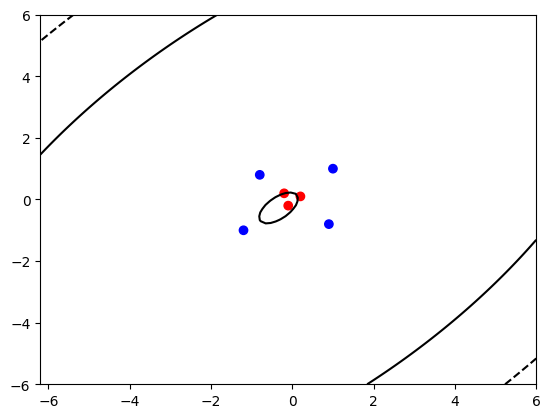

In [206]:
visu_front_ker(df3, X3, y3, alpha3, d=2)

Grâce au noyau polynomial, on a réussi à séparer les points avec une courbe de niveau $0$ qui n'est pas une droite. On a donc réussi à séparer les points avec un noyau non linéaire. On peut tester la visualisation avec un polynôme de degré 3 ou plus élevé.

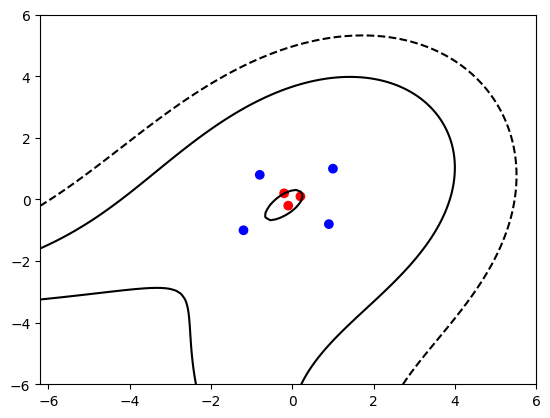

In [207]:
visu_front_ker(df3, X3, y3, alpha3, d=3)

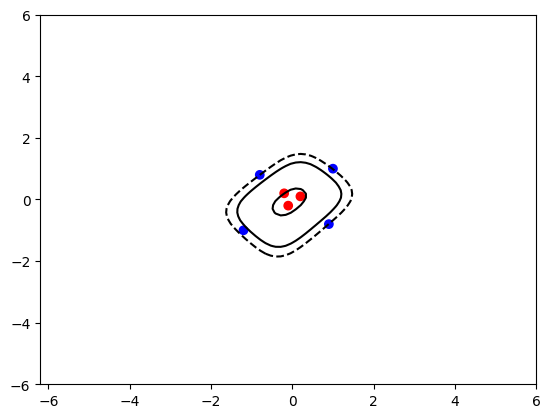

In [210]:
visu_front_ker(df3, X3, y3, alpha3, d=6)

### 2. Cas plus large et cas non séparable linéairement

Tester ce que vous venez de faire sur **data4**.
Que remarquez vous? Comment améliorer la situation?

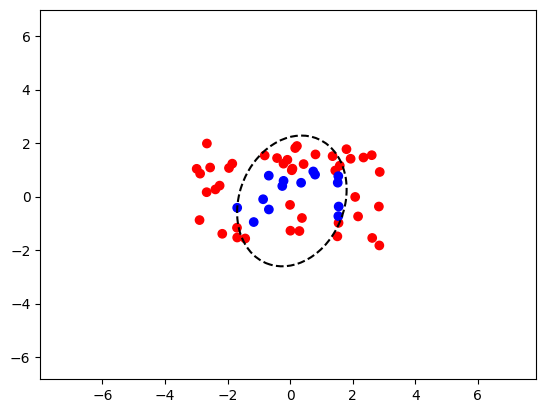

In [183]:
df4, X4, y4, Gram4 = prepa_donnees_ker('data/data4.xlsx')
alpha4 = desc_grad_opti_proj(lambda alpha: J(alpha, Gram4), y4, np.zeros(len(y4)))[-1]
visu_front_ker(df4,X4,y4,alpha4, d=2)

On remarque que le noyau polynomial n'est pas adapté à ce cas. On pourrait notamment essayer d'autres noyaux, tel que le noyau gaussien. On peut aussi essayer de jouer sur les paramètres du noyau polynomial, en prenant par exemple d=3.

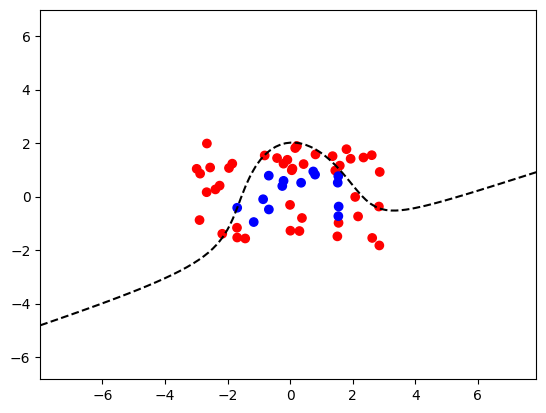

In [188]:
visu_front_ker(df4,X4,y4,alpha4, d=3)

On peut également essayer de prendre un degré de polynôme plus grand, mais cela peut être très coûteux en temps de calcul. Cependant, la précision de la solution peut être améliorée.

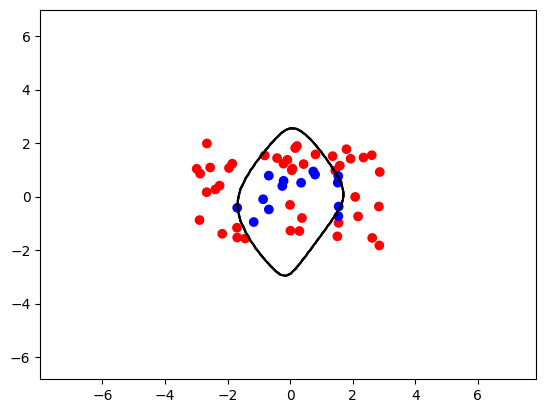

In [189]:
visu_front_ker(df4,X4,y4,alpha4, d=12)